In [2]:
import numpy as np
import nltk
import codecs
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import math as m
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import random
import matplotlib.pyplot as plt
import copy
from scipy.optimize import minimize
import os
import sys, unicodedata
%matplotlib inline

### The method below is for:
<ul>
<li>parsing</li>
<li>preprocessing</li>
<li>stemming</li>
</ul>

In [3]:
my_stop_words = ['','--','***','-','.',',',':',';','!','?','(',')','[',']','Ł','ł','œ',"$",'%','&','#',"''",'``','\n','™','+','-','@','>','<',"'",'~']
stemmer = SnowballStemmer("russian")
def getDatasetAsList(filenames, mode="train", trainsep="\n"):
    dataset_items = np.array([])
    dataset_labels = np.array([],dtype=int)
    for idx,filename in enumerate(filenames):
        labels = []
        test_for_print = []
        file = codecs.open(filename,"r+",encoding="utf-8")
        linesOfFile = file.read()
        if mode=="train":
            paragraphs = np.array(linesOfFile.split(trainsep))
        else:
            paragraphs = np.array(linesOfFile.split("\n"))
            test_for_print = copy.deepcopy(paragraphs)
        splitted_data = [word_tokenize(" ".join(sample.split("/"))) for sample in paragraphs]
        list_of_tokens=[]
        for sublist in splitted_data:
            list_of_tokens.append([stemmer.stem(item.lower()) for item in sublist if item.lower() not in my_stop_words and re.match(r"[0-9]+",item) is None])
        if mode=="train":
            list_of_tokens = [l_o_t for l_o_t in list_of_tokens if l_o_t!=[]]
            labels = np.full(len(list_of_tokens),int(idx))
        else:
            cur_lbl = -1
            labels = np.full(len(list_of_tokens),-2)
        dataset_items = np.append(dataset_items, list_of_tokens)
        dataset_labels = np.append(dataset_labels, labels)
    return (dataset_items, dataset_labels,test_for_print)

In [37]:
dataset_items, dataset_labels, _ = getDatasetAsList(["kidney/0.txt","kidney/1.txt","kidney/2.txt"],trainsep="\n")
X_train, X_val, y_train, y_val = train_test_split(dataset_items, dataset_labels, test_size=0.0, random_state=0)
text_of_labels = ["0","1","2", "unknown"]

### The class below is a main classifyer written based on sklearn convention.

The constructor of a classifyer can obtain Language model and it's parameters or KL-div parameter. Use:
<ul>
<li>LM="J-M" for Jelinec-Mercer smoothing</li>
<li>LM="Dir" for Dirichlet smoothing</li>
<li>LM="KL" for KL-distance as a metrics between query and document</li>
</ul>
Methods:
<ul>
<li> fit(self,X_train, y_train) is used to build a model based on the X_train and X_test</li>
<li> classify(self, X_test) is used to make predictions about labels. Returns arrays of predictions</li>
<li> opt_mu(self) - use used as a parametr of optimization method from sklearn library</li>
</ul>

In [5]:
class MyNaiveBayes:
    common_dict = {}
    common_bigram_dict = {}
    each_class_tokens = []
    each_class_dict = []
    each_class_bigram_dict = []
    def __init__(self, LM="J-M", my_lambda=0, my_mu=0):
        # Defaul LM = Jelinec Mercer with lambda=0
        self.my_lambda = my_lambda
        self.my_mu = my_mu
        self.LM = LM
    def count_KL_dist(self, tokens_list, freq_vocab):
        query_dict = {}
        KL_dist = 0
        for token in tokens_list:
            query_dict[token] = 1 if token not in query_dict else query_dict[token]+1
        for token in tokens_list:
            KL_dist += query_dict[token]*np.log2(freq_vocab[token]) if token in freq_vocab else query_dict[token]*np.log2(1e-30)
        return KL_dist
    def count_dirich_prob(self, tokens_list, freq_vocab, common_dict, idx_of_dict):
        dirc_prob = 0
        mult1 = len(self.each_class_tokens[idx_of_dict])/(len(self.each_class_tokens[idx_of_dict])+self.my_mu)
        mult2 = self.my_mu/(len(self.each_class_tokens[idx_of_dict])+self.my_mu)                                              
        for token in tokens_list:
            if token in freq_vocab:
                dirc_prob += m.log2(mult1*(freq_vocab[token])+mult2*(common_dict[token]))
            elif token not in freq_vocab and token in common_dict:
                dirc_prob += m.log2(mult1*(1e-30)+mult2*(common_dict[token]))
        return dirc_prob
    def count_JM_prob(self,tokens_list, freq_vocab, common_dict):
        log_prob = 0
        for token in tokens_list:
            if token in freq_vocab:
                log_prob += m.log2((1 - self.my_lambda) * (freq_vocab[token]) + self.my_lambda * (common_dict[token]))
            elif token not in freq_vocab and token in common_dict:
                log_prob += m.log2((1 - self.my_lambda) * (1e-30) + self.my_lambda * (common_dict[token]))
        return log_prob
    def count_bigram_prob(self, token_list, freq_vocab, bigram_dict,each_class_bigram_dict_freq):
        log_prob = 0
        for idx,token in enumerate(token_list[:-1]):
            bigram = " ".join([token, token_list[idx+1]])
            if bigram in bigram_dict:
                log_prob += each_class_bigram_dict_freq[bigram]*m.log2((1 - self.my_lambda)*bigram_dict[bigram] + self.my_lambda * (freq_vocab[token]))
            elif token in freq_vocab:
                log_prob += m.log2((1 - self.my_lambda)*(1e-15)+ self.my_lambda * (freq_vocab[token]))
        return log_prob
    def classify(self, X_test):
        classify_result = []
        # Counting probabilities
        for idx, freq_vocab in enumerate(self.each_class_dict):
            if self.LM == "JM":
                classify_result.append([self.count_JM_prob(x_test, freq_vocab, self.common_dict) for x_test in X_test])
            elif self.LM == "Dir":
                classify_result.append([self.count_dirich_prob(x_test, freq_vocab, self.common_dict, idx) for x_test in X_test])
            elif self.LM == "bigramm":
                classify_result.append([self.count_bigram_prob(x_test, freq_vocab, self.each_class_bigram_dict[idx],self.each_class_bigram_dict_freq[idx]) for x_test in X_test])
            else:
                classify_result.append([self.count_KL_dist(x_test, freq_vocab) for x_test in X_test])
        classify_result = np.array(classify_result)
        # For the same predictions make this sample to be "unknown"
        undef_pred = []
        for j in range(0,len(classify_result[0])): 
            if (classify_result[0,j] == classify_result[1,j] and classify_result[1,j] == classify_result[2,j]):
                undef_pred.append(j)
        res = np.argmax(classify_result,axis=0)
        if undef_pred != []:
            res[undef_pred] = -1
        return (res)
    def fit(self, X_train, y_train,**kwargs):
        self.common_dict = {}
        self.common_bigram_dict = {}
        # Creating list of tokens and dictionaries for each class
        self.each_class_dict = [{} for i in range(0, len(np.unique(y_train)))]
        self.each_class_bigram_dict = [{} for i in range(0, len(np.unique(y_train)))]
        self.each_class_tokens = [[] for i in range(0, len(np.unique(y_train)))]
        # Text preprocessing, tokenizing, stemming, removing stop words
        splitted_data = X_train
        for idx, item in enumerate(splitted_data):
            self.each_class_tokens[y_train[idx]].append(item)
        for idx, item in enumerate(self.each_class_tokens):
            for token_list in item:
                for i, token in enumerate(token_list[:-1]):
                    cur_key = " ".join([token_list[i],token_list[i+1]])
                    self.each_class_bigram_dict[idx][cur_key] = 1 if cur_key not in self.each_class_bigram_dict[idx] else self.each_class_bigram_dict[idx][cur_key]+1
                    self.common_bigram_dict[token] = 1 if token not in self.common_bigram_dict else self.common_bigram_dict[token]+1
        for idx, item in enumerate(self.each_class_tokens):
            self.each_class_tokens[idx] = [item for sublist in self.each_class_tokens[idx] for item in sublist]
        # Creating a dictionary
        for idx,all_tokens in enumerate(self.each_class_tokens):
            for token in all_tokens:
                self.each_class_dict[idx][token] = 1 if token not in self.each_class_dict[idx] else self.each_class_dict[idx][token]+1
                self.common_dict[token] = 1 if token not in self.common_dict else self.common_dict[token]+1
        # Frequency -> probability
        total_words = (sum([len(self.each_class_tokens[i]) for i in range(0, len(self.each_class_tokens))]))
        total_bigrams = (sum([item for key, item in self.common_bigram_dict.items()]))
        #print(self.common_dict)
        #print(self.common_bigram_dict)
        self.common_bigram_dict = {key: item/self.common_dict[key.split()[0]] for key, item in self.common_bigram_dict.items()}
        self.common_dict = {key: item/total_words for key, item in self.common_dict.items()}
        self.each_class_dict_freq = copy.deepcopy(self.each_class_dict)
        self.each_class_bigram_dict_freq = copy.deepcopy(self.each_class_bigram_dict)
        for idx, class_dict in enumerate(self.each_class_dict):
            self.each_class_dict[idx] = {key:item/len(self.each_class_tokens[idx]) for key, item in class_dict.items()}
        for idx, class_dict in enumerate(self.each_class_bigram_dict):
            #num_of_bigrams = sum([item for key, item in class_dict.items()])
            self.each_class_bigram_dict[idx] = {key:item/self.each_class_dict_freq[idx][key.split()[0]] for key, item in class_dict.items()}
        #print(self.each_class_bigram_dict[0])
        #print(sum([item for key, item in self.each_class_bigram_dict[2].items()]))
    def get_params(self, deep = False):
        return {'my_lambda':self.my_lambda, 'my_mu':self.my_mu, 'LM':self.LM}

Now let's define score function which will return F1-score

In [6]:
def scorer(estimator, X, y):
    predictions = estimator.classify(X)
    return f1_score(y, predictions, average='macro')

And let's test the classifier based on a KL-distance. The result is computed for line classification (labeling), where each sample is a line from the test resumes.

In [7]:
mnb = MyNaiveBayes("KL",0.11)
mnb.fit(X_train, y_train)
res = mnb.classify(X_train)
f1 = f1_score(y_train, res, average='macro')
print("F1-score",f1)

F1-score 0.96610143669


The example of labeling is presented below, resume lines are preprocced.

In [8]:
for idx in range(0, 10):
    print(" ".join(X_train[idx]), '['+text_of_labels[res[idx]]+']')

c осторожн заболеван печен [2]
с осторожн назнача албендазол пациент с печеночн недостаточн цирроз печен [2]
противопоказан остр гепат цирроз печен [1]
противопоказа при тяжел нарушен функц печен с особ осторожн след назнача препарат при указан в анамнез на заболеван печен [2]
противопоказа при печеночн недостаточн в случа назначен больш доз с осторожн назнача при нарушен функц печен печеночн недостаточн [2]
противопоказан печеночн недостаточн [1]
противопоказа при выражен нарушен функц печен [1]
противопоказа при остр гепат цирроз печен пациент имеющ в анамнез заболеван печен разв на фон прием метилдоп пациент с заболеван ил нарушен функц печен в анамнез дан препарат след назнача с крайн осторожн [2]
с осторожн след применя препарат при печеночн недостаточн коррекц доз не треб [2]
с осторожн след назнача препарат при умерен печеночн недостаточн противопоказан тяжел печеночн недостаточн [1]


Let's optimize parameters mu and lambda for Jelinec-Mercer and Dirichlet language models based on optimal f-1 score.

We will use the whole paragraphs of sections, e.g. whole education paragraph, as a training sample. That's why we will get a little different results.

In [9]:
smoothed_results_JM = []
linspace_Jelinec_Mercer = np.linspace(0,1,10)
for my_lambda in linspace_Jelinec_Mercer:
    mnb = MyNaiveBayes("JM",my_lambda)
    scores = cross_val_score(mnb,X_train, y_train, scoring=scorer, cv=5)
    smoothed_results_JM.append(scores.mean())

/Users/ilyas/anaconda/envs/InfRet/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ilyas/anaconda/envs/InfRet/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Max f-1 for lambda = 0.111111111111 f1= 0.711966168327


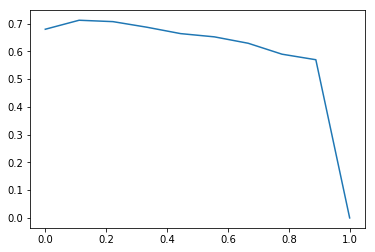

In [10]:
print("Max f-1 for lambda =", linspace_Jelinec_Mercer[np.argmax(smoothed_results_JM)],"f1=",np.max(smoothed_results_JM))
plt.plot(linspace_Jelinec_Mercer, smoothed_results_JM)

In [153]:
smoothed_results = []
linspace_Dirichlet = np.linspace(0,5000,100)
for my_mu in linspace_Dirichlet:
    mnb = MyNaiveBayes("Dir",0,my_mu)
    scores = cross_val_score(mnb,X_train, y_train, scoring=scorer, cv=5)
    smoothed_results.append(scores.mean())

Max f-1 for mu = 0.0 f1= 0.599795037675


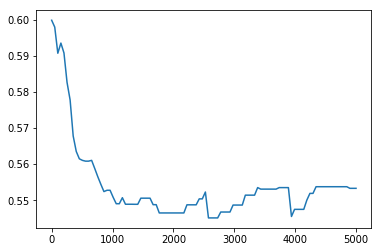

In [13]:
print("Max f-1 for mu =", linspace_Dirichlet[np.argmax(smoothed_results)],"f1=",np.max(smoothed_results))
plt.plot(linspace_Dirichlet, smoothed_results)

Let's try to optimize mu-parameter of the Dirichlet LM using leave-one-out method and optimizing it's likelyhood function. In the example below you can see an example of optimizing using <i>minimize()</i> function from the sklearn. Unfortunatelly it doesn't converge to global maximum. The Newton method was implemented in the MyNaiveBayes class and does not converge too. The reason may be non-convex likelyhood fucntion because of sparse dataset.

In [ ]:
train_table = []
for root, dirs, files in os.walk('/Users/ilyas/Documents/Innopolis/InfRetrieval/pills_online/static/desc'):
    for idx,file in enumerate(files):
        if(file[-3:]=="txt"):
            #print(file)
            with open(root+os.sep+file) as f:
                cur_row = ["-","-","-","-"]
                data = f.readlines()
                title = data[0]
                cur_row[0]=title
                splitted_h_d = "\n".join(data[1:]).split('!#!')
                transl_dict = {'Показания': 'indication', 'Дозировка': 'dosage', 'Противопоказания': 'contra',
                                       'Побочные действия': 'side_effect', 'Фармакологическое действие': 'pharm_action',
                                       'Особые указания': 'spec_instruct', 'Беременность и лактация': 'pregnancy',
                                       'Лекарственное взаимодействие': 'med_interact', 'Фармакокинетика': 'pharm_kinetic',
                                       'Применение в детском возрасте': 'child_policy',
                                       'Клинико-фармакологическая группа': 'clinic_pharm_group',
                                       'Форма выпуска, состав и упаковка': 'form_composition',
                                       'Условия отпуска из аптек': 'distr_policy',
                                       'Условия и сроки хранения': 'expiration_date', 'Передозировка': 'overdosage',
                                       'При нарушениях функции почек': 'kidney', 'При нарушениях функции печени': 'liver',
                                       'Применение в пожилом возрасте': 'old_policy'}
                paste_dict = {}
                for h_d in splitted_h_d:
                        if h_d != '':
                            h_d = h_d.split('#!#\n\n')
                            if(h_d[0]=="Беременность и лактация"):
                                cur_row[1]=h_d[1]
                            elif (h_d[0]=="При нарушениях функции почек"):
                                cur_row[2]=h_d[1]
                            elif (h_d[0]=="При нарушениях функции печени"):
                                cur_row[3]=h_d[1] 
                train_table.append(cur_row)

In [12]:
train_table = np.array(train_table)

In [13]:
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                    if unicodedata.category(chr(i)).startswith('P'))

In [38]:
for i in range(train_table.shape[0]):
    for j in range(1,train_table.shape[1]):
        train_table[i][j] = train_table[i][j].translate(tbl)
contra = [word_tokenize(item) for item in train_table[:,2]]
contra = [[stemmer.stem(token.lower()) for token in token_list if token.lower() not in my_stop_words and re.match(r"[0-9]+",token) is None] 
             for token_list in contra]

In [39]:
mnb = MyNaiveBayes("KL",0.11)
mnb.fit(X_train, y_train)
res = mnb.classify(contra)

In [40]:
with open("kidney_warnings.txt", "w") as out_f:
    for idx, r in enumerate(res):
        out_str = "\t".join([train_table[idx,0][:-1],str(r)])
        out_f.write(out_str+"\n")